# Benchmark GAT model on the ESOL dataset

In [1]:
import sys
sys.path.append('../../../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


from molgraph.chemistry.benchmark import configs
from molgraph.chemistry.benchmark import tf_records
from molgraph.chemistry import datasets
from molgraph.losses import masked_losses
from molgraph.metrics import masked_metrics


### Define molecular graph encoder

In [2]:
from molgraph.chemistry import features
from molgraph.chemistry import AtomFeaturizer, BondFeaturizer
from molgraph.chemistry import MolecularGraphEncoder

atom_encoder = AtomFeaturizer([
    features.Symbol(),
    features.Hybridization(),
    features.FormalCharge(),
    features.TotalNumHs(),
    features.TotalValence(),
    features.NumRadicalElectrons(),
    features.Degree(),
    features.ChiralCenter(),
    features.Aromatic(),
    features.Ring(),
    features.Hetero(),
    features.HydrogenDonor(),
    features.HydrogenAcceptor(),
    features.CIPCode(),
    features.ChiralCenter(),
    features.RingSize(),
    features.Ring(),
    features.CrippenLogPContribution(),
    features.CrippenMolarRefractivityContribution(),
    features.TPSAContribution(),
    features.LabuteASAContribution(),
    features.GasteigerCharge(),
])

bond_encoder = BondFeaturizer([
    features.BondType(),
    features.Conjugated(),
    features.Rotatable(),
    features.Ring(),
    features.Stereo(),
])

encoder = MolecularGraphEncoder(
    atom_encoder,
    bond_encoder,
    positional_encoding_dim=16,
    self_loops=False
)

### Obtain dataset and molecular graph

In [3]:
esol = datasets.get('esol')

x_train = encoder(esol['train']['x'])
y_train = esol['train']['y']

x_val = encoder(esol['validation']['x'])
y_val = esol['validation']['y']

x_test = encoder(esol['test']['x'])
y_test = esol['test']['y']

type_spec = x_train.merge().unspecific_spec

### `tf.data.Dataset` API

In [4]:
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .batch(32)
    .map(lambda x, *args: (x.merge(), *args), -1)
    .prefetch(-1)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(32)
    .map(lambda x, *args: (x.merge(), *args), -1)
    .prefetch(-1)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(32)
    .map(lambda x, *args: (x.merge(), *args), -1)
    .prefetch(-1)
)

### `tf.keras.Sequential` API

In [5]:
from molgraph.layers import GATConv
from molgraph.layers import LaplacianPositionalEncoding
from molgraph.layers import Readout
from molgraph.layers import MinMaxScaling

node_preprocessing = MinMaxScaling(
    feature='node_feature', feature_range=(0, 1), threshold=True)
edge_preprocessing = MinMaxScaling(
    feature='edge_feature', feature_range=(0, 1), threshold=True)

node_preprocessing.adapt(train_ds.map(lambda x, *args: x))
edge_preprocessing.adapt(train_ds.map(lambda x, *args: x))

model = tf.keras.Sequential([
    keras.layers.Input(type_spec=type_spec),
    node_preprocessing,
    edge_preprocessing,
    LaplacianPositionalEncoding(),
    GATConv(),
    GATConv(),
    GATConv(),
    Readout(),
    keras.layers.Dense(1024, 'relu'),
    keras.layers.Dense(1024, 'relu'),
    keras.layers.Dense(y_train.shape[-1])
])


optimizer = keras.optimizers.Adam(1e-4)
loss = keras.losses.MeanAbsoluteError(name='mae')
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor=f'val_loss',
        factor=0.1,
        patience=10,
        min_lr=1e-6,
        mode='min',
    ),
    keras.callbacks.EarlyStopping(
        monitor=f'val_loss',
        patience=20,
        mode='min',
        restore_best_weights=True,
    )
]

model.compile(optimizer, loss)
history = model.fit(
    train_ds, callbacks=callbacks, validation_data=val_ds, epochs=100
)
model.evaluate(test_ds)

Epoch 1/100
29/29 [==============================] - 14s 156ms/step - loss: 1.6118 - val_loss: 2.8704 - lr: 1.0000e-04
Epoch 2/100
29/29 [==============================] - 2s 59ms/step - loss: 1.0643 - val_loss: 2.8552 - lr: 1.0000e-04
Epoch 3/100
29/29 [==============================] - 2s 59ms/step - loss: 0.8667 - val_loss: 2.7933 - lr: 1.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 39ms/step - loss: 0.8038 - val_loss: 2.7950 - lr: 1.0000e-04
Epoch 5/100
29/29 [==============================] - 2s 59ms/step - loss: 0.7499 - val_loss: 2.7086 - lr: 1.0000e-04
Epoch 6/100
29/29 [==============================] - 2s 60ms/step - loss: 0.7562 - val_loss: 2.6720 - lr: 1.0000e-04
Epoch 7/100
29/29 [==============================] - 2s 62ms/step - loss: 0.6782 - val_loss: 2.5656 - lr: 1.0000e-04
Epoch 8/100
29/29 [==============================] - 1s 50ms/step - loss: 0.6904 - val_loss: 2.4806 - lr: 1.0000e-04
Epoch 9/100
29/29 [==============================] - 1s 52ms/s

29/29 [==============================] - 1s 48ms/step - loss: 0.3025 - val_loss: 0.4298 - lr: 1.0000e-05
Epoch 71/100
29/29 [==============================] - 2s 60ms/step - loss: 0.3256 - val_loss: 0.4551 - lr: 1.0000e-05
Epoch 72/100
29/29 [==============================] - 2s 58ms/step - loss: 0.3134 - val_loss: 0.4207 - lr: 1.0000e-05
Epoch 73/100
29/29 [==============================] - 2s 59ms/step - loss: 0.3386 - val_loss: 0.4372 - lr: 1.0000e-05
Epoch 74/100
29/29 [==============================] - 1s 33ms/step - loss: 0.3280 - val_loss: 0.4735 - lr: 1.0000e-05
Epoch 75/100
29/29 [==============================] - 1s 22ms/step - loss: 0.3243 - val_loss: 0.4397 - lr: 1.0000e-05
Epoch 76/100
29/29 [==============================] - 1s 22ms/step - loss: 0.3324 - val_loss: 0.4420 - lr: 1.0000e-05
Epoch 77/100
29/29 [==============================] - 1s 21ms/step - loss: 0.3501 - val_loss: 0.4297 - lr: 1.0000e-05
Epoch 78/100
29/29 [==============================] - 1s 46ms/step - 

0.43574243783950806

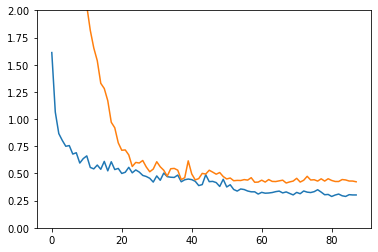

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0, 2);